# Stable Diffusion Notebook UI
Main workflow reference: https://medium.com/@natsunoyuki/using-civitai-models-with-diffusers-package-45e0c475a67e

Notebook reference: https://github.com/woctezuma/stable-diffusion-colab

In [1]:
%pip install --upgrade diffusers transformers mediapy compel accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 26.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [2]:
# restart to use newly installed packages
restart = False # @param {type:"boolean"}
# @markdown > This is usually necessary for releasing RAM and VRAM.
if restart:
    import os
    os._exit(0)  # Restart the notebook

In [3]:
# @markdown ### **Fetch model file**
import os


mode = "http" # @param ['http', 'gdrive', 'git', 'local']
location = "https://huggingface.co/mirroring/civitai_mirror/resolve/main/models/Stable-diffusion/AnythingV5V3_v5PrtRE.safetensors" # @param {type:"string"}
model_filename = location.split('/')[-1]
match mode:
  case "http":
    !test -f $model_filename || wget $location
  case "gdrive":
    from google.colab import drive

    try:
       drive_path = "/content/drive"
       drive.mount(drive_path,force_remount=False)
    except:
       print("...error mounting drive or with drive path variables")
  case "git":
    !git clone --recursive $location
  case _:
    # default to local mode
    pass

if model_filename.endswith(".safetensors"):
  !test -f convert_original_stable_diffusion_to_diffusers.py || wget https://raw.githubusercontent.com/huggingface/diffusers/v$(pip show diffusers | grep Version | awk '{print $2}')/scripts/convert_original_stable_diffusion_to_diffusers.py
  model_dir = model_filename.split('.')[0]
  if mode == "http":
    location = model_filename
  !python convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path $location \
      --dump_path $model_dir/ \
      --from_safetensors
elif mode != "http" and os.path.isdir(location):
  # use model directory directly
  model_dir = location

--2024-04-15 12:52:46--  https://huggingface.co/mirroring/civitai_mirror/resolve/main/models/Stable-diffusion/AnythingV5V3_v5PrtRE.safetensors
Resolving huggingface.co (huggingface.co)... 18.239.50.49, 18.239.50.16, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/7f/f4/7ff4da9ea95382d37e64e2f21cf395e6e1893c4761b430a659d90d6c31da469c/7f96a1a9ca9b3a3242a9ae95d19284f0d2da8d5282b42d2d974398bf7663a252?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27AnythingV5V3_v5PrtRE.safetensors%3B+filename%3D%22AnythingV5V3_v5PrtRE.safetensors%22%3B&Expires=1713444766&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMzQ0NDc2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83Zi9mNC83ZmY0ZGE5ZWE5NTM4MmQzN2U2NGUyZjIxY2YzOTVlNmUxODkzYzQ3NjFiNDMwYTY1OWQ5MGQ2YzMxZGE0NjljLzdmOTZhMWE5Y2E5Y

In [4]:
import mediapy as media
import random
import os
import sys
import gc

import torch
from diffusers import DiffusionPipeline
import transformers

# @markdown #### Pipeline Settings

clip_skip = 2 # @param {type:"slider", min:1, max:12, step:1}
# @markdown > Clip skip = 1 uses the all text encoder layers.
# @markdown >
# @markdown > Clip skip = 2 skips the last text encoder layer.
force_cpu_processing = False # @param {type:"boolean"}
# @markdown > force using CPU device for interference
force_fp32_processing = False # @param {type:"boolean"}
# @markdown > force float32 processing format. Usually needed when image results are black.
use_accelerate = False # @param {type:"boolean"}
# @markdown > Use accelerate to fully utilize all GPUs.

torch.set_num_threads(os.cpu_count())
if use_accelerate:
    # Avoids initializing CUDA before processing
    device = torch.device("cpu")
    torch_dtype = torch.float16
elif not force_cpu_processing and torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32

if force_fp32_processing:
  torch_dtype = torch.float32

# clean pipeline if exists
if "pipe" in locals():
  del pipe
  gc.collect()
  torch.cuda.empty_cache()

pipeline_kwargs = dict()
if clip_skip > 2:
  pipeline_kwargs['text_encoder'] = transformers.CLIPTextModel.from_pretrained(
      "runwayml/stable-diffusion-v1-5",
      subfolder = "text_encoder",
      num_hidden_layers = 12 - (clip_skip - 1),
      torch_dtype = torch_dtype
  )

if not use_accelerate:
    # Use late pipeline initializations for accelerate
    if clip_skip > 2:
        pipeline_kwargs['text_encoder'] = transformers.CLIPTextModel.from_pretrained(
          "runwayml/stable-diffusion-v1-5",
          subfolder = "text_encoder",
          num_hidden_layers = 12 - (clip_skip - 1),
          torch_dtype = torch_dtype
        )
    pipe = DiffusionPipeline.from_pretrained(
        model_dir,
        safety_checker = None,
        torch_dtype = torch_dtype,
        **pipeline_kwargs,
      ).to(device)

    if device.type != 'cpu':
        pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
# @markdown # Prepare utils functions
# Prompt embeddings to overcome CLIP 77 token limit.
# https://github.com/huggingface/diffusers/issues/2136
# https://huggingface.co/docs/diffusers/using-diffusers/weighted_prompts
from compel import Compel, ReturnedEmbeddingsType
from diffusers import StableDiffusionXLPipeline
from accelerate import Accelerator


def get_prompt_embeddings(
    pipeline,
    prompt,
    negative_prompt,
    device = torch.device("cpu")
):
    if isinstance(pipeline, StableDiffusionXLPipeline):
        compel = Compel(
          tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] ,
          text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
          truncate_long_prompts=False,
          returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
          requires_pooled=[False, True],
          device=device
        )
        prompt_embeds, pooled_prompt_embeds = compel(prompt)
        negative_prompt_embeds, negative_pooled_prompt_embeds = compel(negative_prompt)
    else:
        compel = Compel(
          tokenizer=pipeline.tokenizer ,
          text_encoder=pipeline.text_encoder,
          truncate_long_prompts=False,
          returned_embeddings_type = ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NORMALIZED if clip_skip > 1 \
            else ReturnedEmbeddingsType.LAST_HIDDEN_STATES_NORMALIZED,
          requires_pooled=False,
          device=device
        )
        prompt_embeds, pooled_prompt_embeds = compel(prompt), None
        negative_prompt_embeds, negative_pooled_prompt_embeds = compel(negative_prompt), None

    prompt_embeds, negative_prompt_embeds = compel.pad_conditioning_tensors_to_same_length([prompt_embeds, negative_prompt_embeds])
    return prompt_embeds, pooled_prompt_embeds, negative_prompt_embeds, negative_pooled_prompt_embeds

def accelerated_generate(h, w, cfg_scale, num_inference_steps, batch_size, seeds, kwargs, result_list, use_prompt_embeddings):
    accelerator = Accelerator()
    device = accelerator.device

    pipe = DiffusionPipeline.from_pretrained(
        model_dir,
        safety_checker = None,
        torch_dtype = torch_dtype,
        **pipeline_kwargs,
      ).to(device)
    pipe.to(device)

    if use_prompt_embeddings:
        prompt_embeds, pooled_prompt_embeds, negative_prompt_embeds, negative_pooled_prompt_embeds = get_prompt_embeddings(
            pipe,
            kwargs.pop('prompt'),
            kwargs.pop('negative_prompt'),
            device = device
        )
        if isinstance(pipe, StableDiffusionXLPipeline):
            kwargs += {
                'pooled_prompt_embeds': pooled_prompt_embeds,
                'negative_pooled_prompt_embeds': negative_pooled_prompt_embeds,
            }
        kwargs['prompt_embeds'] = prompt_embeds
        kwargs['negative_prompt_embeds'] = negative_prompt_embeds
    else:
        kwargs['prompt'] = prompt
        kwargs['negative_prompt'] = negative_prompt

    with accelerator.split_between_processes(seeds) as task_seeds:
        images = pipe(
                height = h,
                width = w,
                guidance_scale = cfg_scale,
                num_inference_steps = num_inference_steps,
                num_images_per_prompt = len(task_seeds),
                generator = [torch.Generator(device).manual_seed(s) for s in task_seeds],
                **kwargs,
            ).images
        result_list.extend(zip(images, task_seeds))

  0%|          | 0/30 [00:00<?, ?it/s]

""

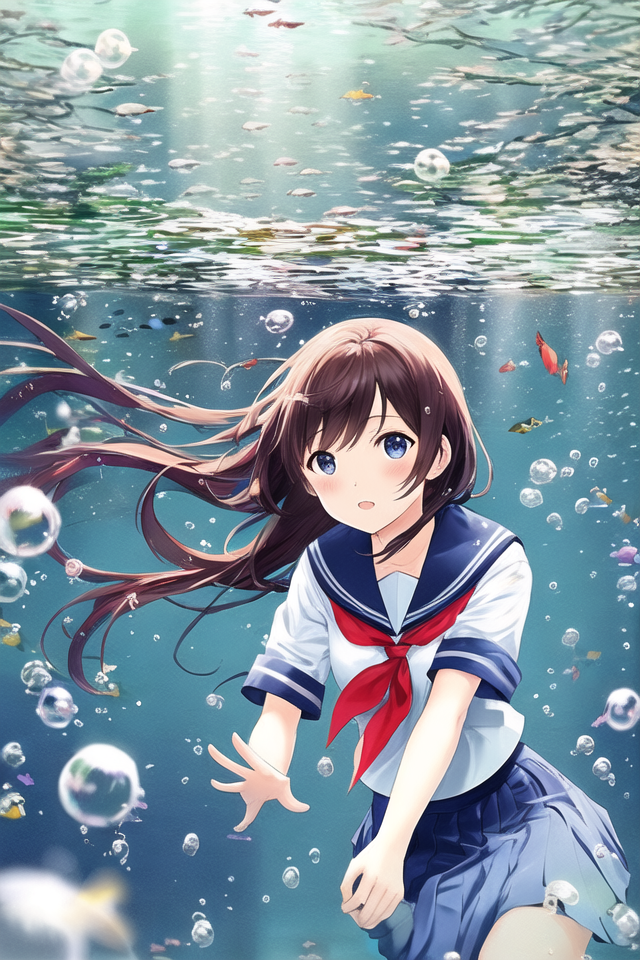

In [6]:
# @markdown ### **Prompts**
# @markdown > Default parameters are from image https://civitai.com/images/963361
prompt = "bubble, rating:safe, air_bubble, underwater, 1girl, fish, long_hair, submerged, school_uniform, serafuku, solo, water, skirt, neckerchief, short_sleeves,(Impressionism:1.4)," # @param {type:"string"}
negative_prompt = "(mutated hands and fingers:1.5 ),(mutation, poorly drawn :1.2),(long body :1.3),(mutation, poorly drawn :1.2),liquid body,text font ui,long neck,uncoordinated body,fused ears,(ugly:1.4),one hand with more than 5 fingers,one hand with less than 5 fingers," # @param {type:"string"}
use_prompt_embeddings = True # @param {type:"boolean"}
# @markdown > Prompt embeddings: Overcome CLIP 77 tokens limit.

# @markdown ### **Image settings**
w = 640 # @param {type:"slider", min:64, max:2048, step:8}
h = 960 # @param {type:"slider", min:64, max:2048, step:8}
batch_count = 1 # @param {type:"integer"}
batch_size = 1 # @param {type:"integer"}

# @markdown ### **Generation settings**
cfg_scale = 9 # @param {type:"slider", min:1, max:27, step:0.5}
num_inference_steps = 30 # @param {type:"slider", min:1, max:150, step:1}

init_seed = 1678803042 # @param {type: "integer"}
#  @markdown > seed: set -1 for random seed

# Arguments preparation
results = []
seeds = [
    random.randint(0, sys.maxsize) if init_seed == -1
    else init_seed + i
    for i in range(batch_count * batch_size)
]
# round image size to be divisible by 8
w -= w % 8
h -= h % 8

kwargs = dict()
if use_prompt_embeddings and not use_accelerate:
    # for accelerate, embedding should be generated in forked processes with accelerate devices.
    prompt_embeds, pooled_prompt_embeds, negative_prompt_embeds, negative_pooled_prompt_embeds = get_prompt_embeddings(
      pipe,
      prompt,
      negative_prompt,
      device = device
    )
    if isinstance(pipe, StableDiffusionXLPipeline):
        kwargs = {
            'pooled_prompt_embeds': pooled_prompt_embeds,
            'negative_pooled_prompt_embeds': negative_pooled_prompt_embeds,
        }
    kwargs['prompt_embeds'] = prompt_embeds
    kwargs['negative_prompt_embeds'] = negative_prompt_embeds
else:
    kwargs['prompt'] = prompt
    kwargs['negative_prompt'] = negative_prompt

for i in range(batch_count):
    batched_seeds = seeds[i * batch_size: (i + 1) * batch_size]
    if use_accelerate:
        from accelerate import notebook_launcher
        from multiprocessing import Manager

        with Manager() as manager:
            result_list = manager.list()
            notebook_launcher(
                accelerated_generate,
                (h, w, cfg_scale, num_inference_steps, batch_size, batched_seeds, kwargs, result_list, use_prompt_embeddings,),
                num_processes=torch.cuda.device_count()
            )
            results.extend(result_list)
            # Todo: may produce out of order image list
            # Todo: use fp16 with accelerate
    else:
        images = pipe(
            height = h,
            width = w,
            guidance_scale = cfg_scale,
            num_inference_steps = num_inference_steps,
            num_images_per_prompt = batch_size,
            generator = [torch.Generator(device).manual_seed(s) for s in batched_seeds],
            **kwargs,
        ).images
        results.extend(zip(images, batched_seeds))

media.show_images([r[0] for r in results])

In [7]:
# @markdown Save Images with seeds
!mkdir -pv outputs

for img, seed in results:
    filename = f"outputs/{seed}.png"
    img.save(filename)

!zip -rv -9 outputs.zip outputs/

mkdir: created directory 'outputs'
  adding: outputs/	(in=0) (out=0) (stored 0%)
  adding: outputs/1678803042.png 	(in=1067213) (out=1066999) (deflated 0%)
total bytes=1067213, compressed=1066999 -> 0% savings
